In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
import os

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [22]:
df = pd.read_csv('./open/train.csv')
df_test = pd.read_csv('./open/test.csv')
submission = pd.read_csv('./open/sample_submission.csv')

In [23]:
df.describe()

,Age,Working_Week (Yearly),Gains,Losses,Dividends,Income
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,35.632500,34.943050,383.129500,40.202150,123.451450,554.565250
std,17.994414,22.254592,4144.247487,279.182677,1206.949429,701.553155
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,7.000000,0.000000,0.000000,0.000000,0.000000
50%,34.000000,52.000000,0.000000,0.000000,0.000000,500.000000
75%,47.000000,52.000000,0.000000,0.000000,0.000000,875.000000
max,90.000000,52.000000,99999.000000,4356.000000,45000.000000,9999.000000


In [24]:
summary = df.describe()

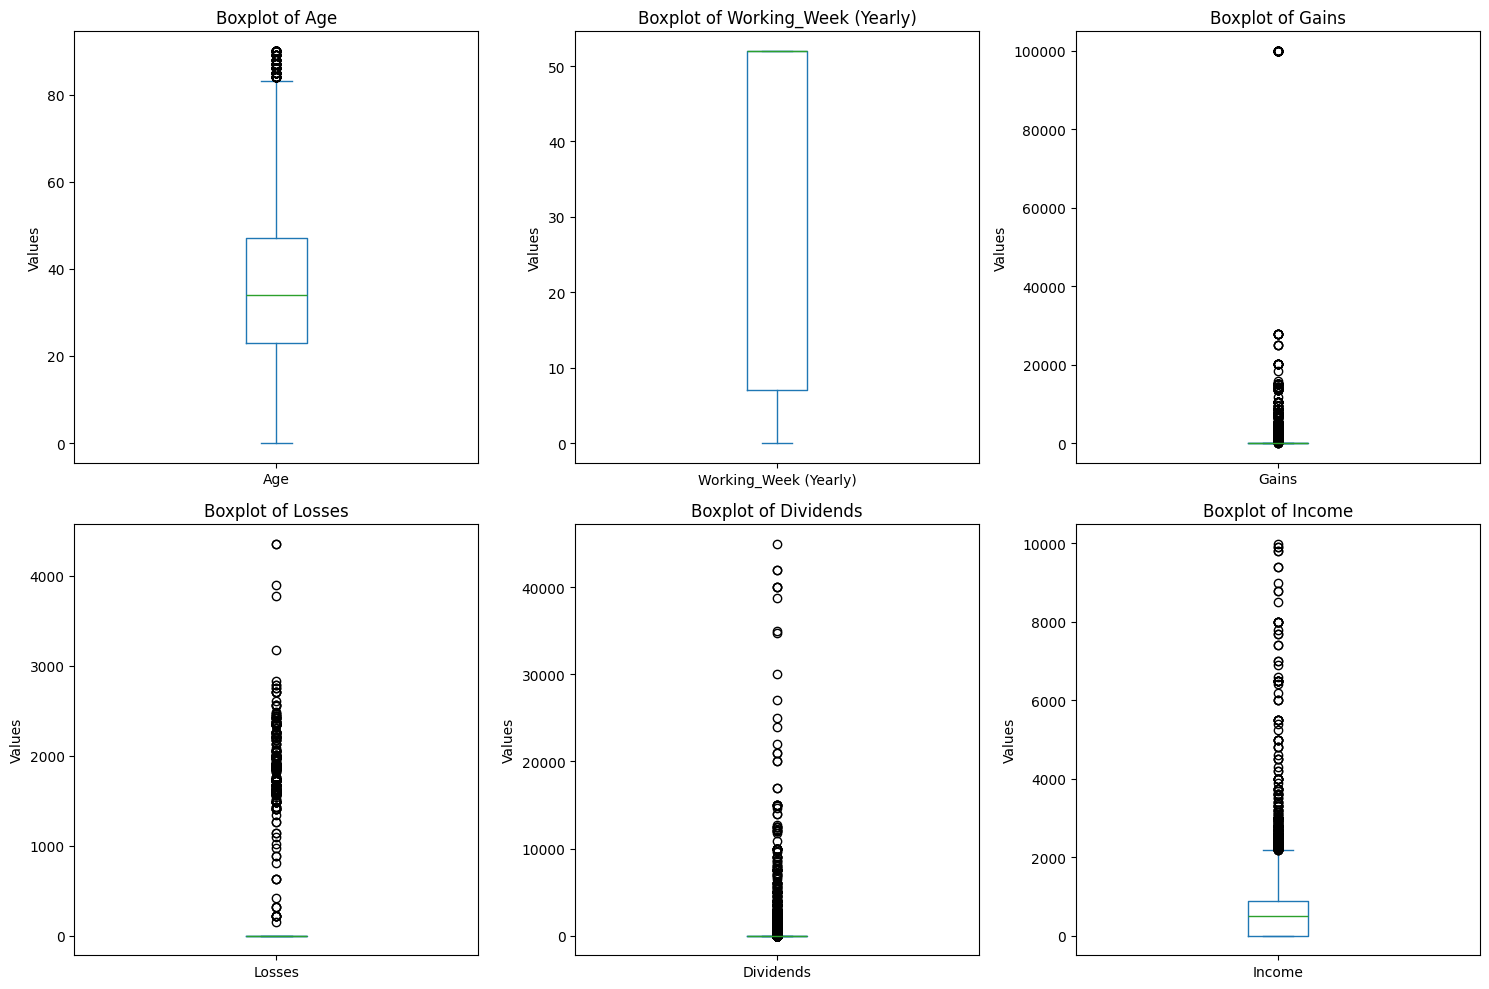

In [25]:
# 각 컬럼에 대한 상자 그림(boxplot) 그리기
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

for i, column in enumerate(summary.columns):
    row = i // 3
    col = i % 3
    df[column].plot(ax=axes[row, col], kind='box', title=f'Boxplot of {column}')
    axes[row, col].set_ylabel('Values')

plt.tight_layout()
plt.show()

In [26]:
df['Income'].describe()

count    20000.000000
mean       554.565250
std        701.553155
min          0.000000
25%          0.000000
50%        500.000000
75%        875.000000
max       9999.000000
Name: Income, dtype: float64

In [27]:
income_median = 500

In [28]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [29]:
df['Gains'].describe()

count    20000.000000
mean       383.129500
std       4144.247487
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: Gains, dtype: float64

In [30]:
df = df.drop(['ID', 'Household_Status'], axis=1)
df_test = df_test.drop(['ID', 'Household_Status'], axis=1)

In [31]:
object_columns = df.select_dtypes(include=['object']).columns

In [32]:
list(object_columns)

['Gender',
 'Education_Status',
 'Employment_Status',
 'Industry_Status',
 'Occupation_Status',
 'Race',
 'Hispanic_Origin',
 'Martial_Status',
 'Household_Summary',
 'Citizenship',
 'Birth_Country',
 'Birth_Country (Father)',
 'Birth_Country (Mother)',
 'Tax_Status',
 'Income_Status']

In [39]:
df

,Age,Gender,Education_Status,Employment_Status,Working_Week (Yearly),Industry_Status,Occupation_Status,Race,Hispanic_Origin,Martial_Status,...,Citizenship,Birth_Country,Birth_Country (Father),Birth_Country (Mother),Tax_Status,Gains,Losses,Dividends,Income_Status,Income
0,63,M,Middle (7-8),Full-Time,4,Social Services,Services,White,All other,Married,...,Native,US,US,US,Nonfiler,0,0,0,Unknown,425
1,37,M,Associates degree (Vocational),Full-Time,52,Entertainment,Services,White,All other,Separated,...,Native,US,US,US,Single,0,0,0,Under Median,0
2,58,F,High graduate,Full-Time,52,Manufacturing (Non-durable),Admin Support (include Clerical),Black,All other,Married,...,Native,US,US,US,Married Filling Jointly both under 65 (MFJ),3411,0,0,Under Median,860
3,44,M,High graduate,Full-Time,52,Retail,Technicians & Support,White,All other,Divorced,...,Native,US,US,US,Single,0,0,0,Under Median,850
4,37,F,High graduate,Full-Time,52,Retail,Sales,White,All other,Divorced,...,Native,US,US,US,Head of Household (HOH),0,0,0,Unknown,570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,33,M,High graduate,Children or Armed Forces,52,Manufacturing (Durable),Handlers/Cleaners,White,All other,Single,...,Native,US,US,US,Single,0,0,0,Under Median,1300
19996,20,F,College,Full-Time,12,Education,Admin Support (include Clerical),White,Mexican-American,Single,...,Native,US,Mexico,Mexico,Nonfiler,0,0,0,Under Median,850
19997,22,M,College,Children or Armed Forces,52,Transportation,Technicians & Support,White,All other,Single,...,Native,US,US,US,Single,0,0,0,Unknown,999
19998,76,F,High graduate,Not Working,0,Not in universe or children,Unknown,White,All other,Widowed,...,Native,US,Scotland,England,Single,0,0,0,Under Median,0


In [33]:
X = df.drop('Income', axis=1)
y = df['Income']
y = np.log(y+100)
X_cat = X[X.columns.difference(X.describe().columns)]
cat_features = list(X_cat.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=10)

In [34]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)

In [35]:
model = CatBoostRegressor()
model.fit(train_pool)
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

Learning rate set to 0.06063
0:	learn: 1.1458572	total: 19.9ms	remaining: 19.9s
1:	learn: 1.1203447	total: 37.9ms	remaining: 18.9s
2:	learn: 1.0976977	total: 50.7ms	remaining: 16.9s
3:	learn: 1.0770655	total: 65.9ms	remaining: 16.4s
4:	learn: 1.0582488	total: 83.2ms	remaining: 16.5s
5:	learn: 1.0417242	total: 97.6ms	remaining: 16.2s
6:	learn: 1.0262337	total: 111ms	remaining: 15.7s
7:	learn: 1.0130343	total: 124ms	remaining: 15.3s
8:	learn: 1.0001569	total: 141ms	remaining: 15.6s
9:	learn: 0.9888590	total: 158ms	remaining: 15.7s
10:	learn: 0.9785492	total: 174ms	remaining: 15.7s
11:	learn: 0.9693539	total: 191ms	remaining: 15.7s
12:	learn: 0.9606700	total: 209ms	remaining: 15.9s
13:	learn: 0.9527897	total: 226ms	remaining: 15.9s
14:	learn: 0.9457485	total: 245ms	remaining: 16.1s
15:	learn: 0.9400222	total: 268ms	remaining: 16.5s
16:	learn: 0.9344164	total: 290ms	remaining: 16.8s
17:	learn: 0.9295765	total: 306ms	remaining: 16.7s
18:	learn: 0.9259035	total: 316ms	remaining: 16.3s
19:	le

In [36]:
test_pool = Pool(df_test, cat_features = cat_features)
y_submission = model.predict(test_pool)
submission['Income'] = np.exp(y_submission) - 100

In [37]:
submission['Income'] = submission['Income'].apply(lambda x: 0 if x < 0 else x)

In [42]:
submission.describe()

,Income
count,10000.000000
mean,357.763769
std,264.618748
min,0.000000
25%,101.407255
50%,370.295430
75%,542.786430
max,1395.530997
